In [13]:
from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

jax.config.update("jax_enable_x64", True)

## Processing Fits File

In [14]:
def process_image(image, scale_factor=1, offset=1):
    scaled_image = (image[::scale_factor, ::scale_factor])[1::, 1::]
    cropped_image = image[70:210, 70:210]
    def safe_float32_conversion(value):
        try:
            return np.float32(value)
        except (ValueError, TypeError):
            print("This value is unjaxable: " + str(value))
    fin_image = np.nan_to_num(cropped_image)
    fin_image = np.vectorize(safe_float32_conversion)(fin_image)
    return fin_image

Filename: Fits/hd157587_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     459   ()      
  1  SCI           1 ImageHDU       138   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

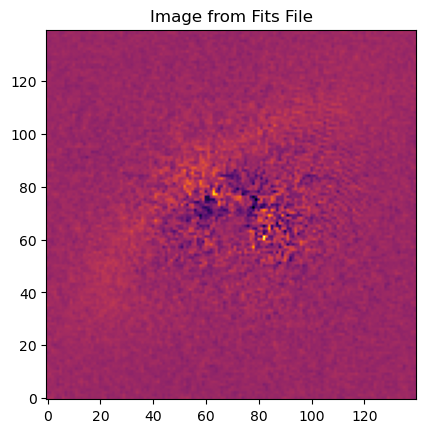

In [15]:
fits_image_filepath = "Fits/hd157587_H_pol.fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
target_image = process_image(hdul['SCI'].data[1,:,:])

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [16]:
from optimize import quick_optimize_cent
from optimize import quick_image_cent
from disk_utils_jax import jax_model_all_1d
from regression import log_likelihood_1d_pos_all_pars_spline
from scipy.optimize import minimize
from SLD_utils import *

### Generating Error Map

In [17]:
# Creating error map
def create_circular_err_map(image_shape, iradius, oradius, noise_level):
    err_map = jnp.zeros(image_shape)
    center = image_shape[0]/2
    y, x = jnp.ogrid[:image_shape[0], :image_shape[1]]
    distance = jnp.sqrt((x - center) ** 2 + (y - center) ** 2)  
    err_map = jnp.where(distance <= oradius, noise_level, 1e8)
    err_map = jnp.where(distance >= iradius, err_map, 1e8)
    return err_map

def create_err_map_from_data(filepath):
    data = (fits.open(filepath)[1].data[2,:,:])[70:210, 70:210]
    y,x = np.indices(data.shape)
    y -= data.shape[0]//2
    x -= data.shape[1]//2 
    radii = np.sqrt(x**2 + y**2) 
    annulus_width = 5
    noise_array = np.zeros_like(data)
    for i in range(0, int(np.max(radii)//annulus_width) ): 
        indices = (radii > i*annulus_width) & (radii <= (i+1)*annulus_width) 
        noise_array[indices] = np.nanstd(data[indices])
    mask_rad = 9
    mask = radii <= mask_rad
    noise_array[mask] = 0


err_map = create_circular_err_map(target_image.shape, 12, 83, 15)

### Getting Optimal Fit

In [21]:
target_image = jnp.asarray(target_image)

init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], jnp.linspace(1, -1, 6))
init_disk_guess = jnp.array([5., -5., 79.0, 70.0, 127.0])
init_cent_guess = jnp.array([70., 70.])
init_guess = jnp.concatenate([init_cent_guess, init_disk_guess, init_knot_guess])

soln = quick_optimize_cent(target_image, err_map, method = None, init_params=init_guess, iters = 2000, PSFModel=EMP_PSF, pxInArcsec=0.01414, distance = 100.51)
print(soln)

# soln is an array of all the optimal parameters
# 0: x position of center, 1: y position of center, 2: alpha_in, 3: alpha_out, 4: sma, 5: inclination, 6: position_angle, (7-12): y positions of spf spline knots (linspace(1,-1,6)) 

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 80523.93548615591
        x: [ 7.054e+01  7.220e+01 ...  8.712e-04  3.763e-04]
      nit: 89
      jac: [ 0.000e+00  0.000e+00 ...  5.811e-01  2.773e-01]
 hess_inv: [[ 2.710e-01  1.331e-01 ... -1.738e-05 -2.441e-05]
            [ 1.331e-01  1.140e+00 ... -1.496e-04 -2.578e-04]
            ...
            [-1.738e-05 -1.496e-04 ...  7.064e-08  3.856e-08]
            [-2.441e-05 -2.578e-04 ...  3.856e-08  2.506e-07]]
     nfev: 1932
     njev: 138
[ 7.05418503e+01  7.22014691e+01  1.04697624e+01 -2.69105095e+00
  7.66106508e+01  7.06512071e+01  1.28142218e+02  5.28720971e-03
  3.11939958e-03  2.76948283e-03  1.77123250e-03  8.71204361e-04
  3.76345143e-04]


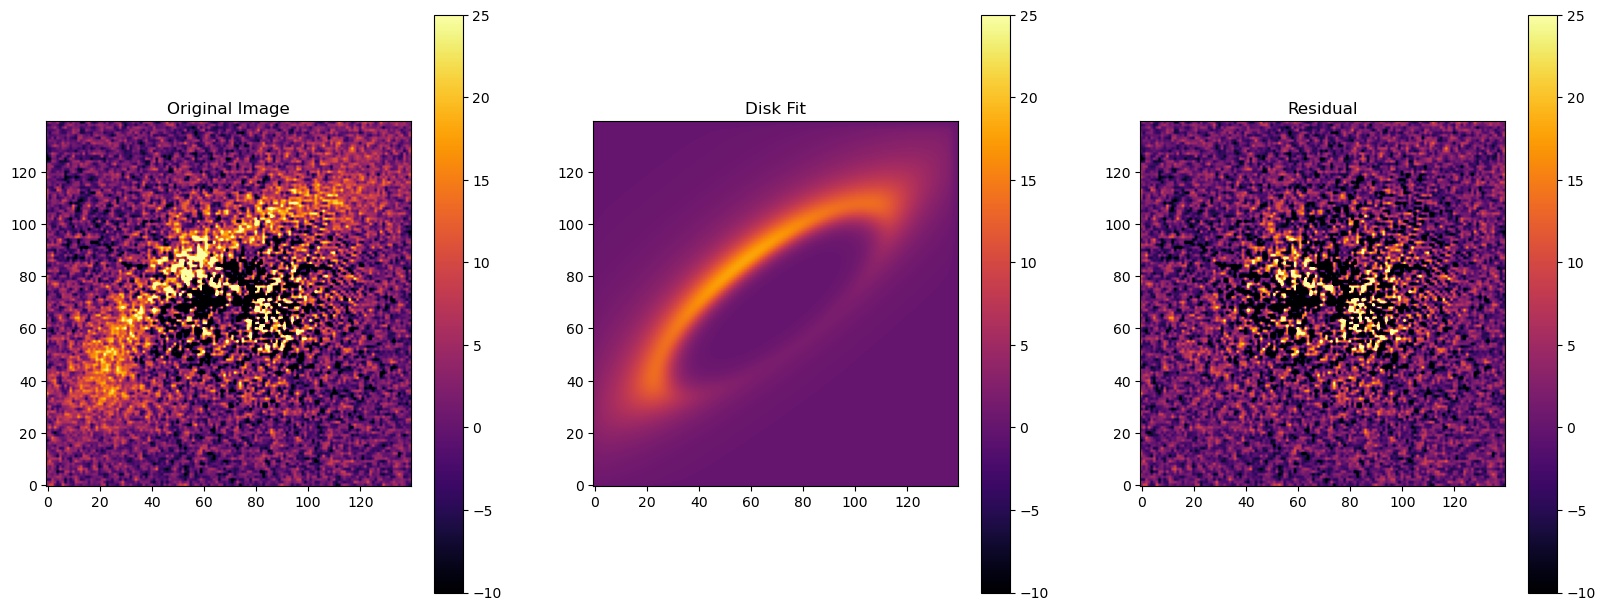

In [30]:
optimal_image = quick_image_cent(soln, PSFModel=EMP_PSF, pxInArcsec=0.01414, distance = 100.51)

fig, axes = plt.subplots(1,3, figsize=(20,10))

min, max = -10, 25

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)
im.set_clim(min, max)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)
im.set_clim(min, max)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)
im.set_clim(min, max)

### Initial Guess

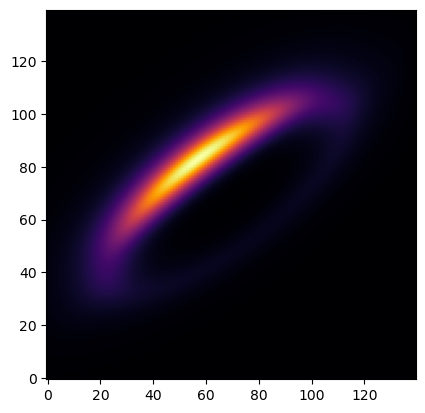

In [20]:
init_knot_guess = DoubleHenyeyGreenstein_SPF.compute_phase_function_from_cosphi([0.5, 0.5, 0.5], jnp.linspace(1, -1, 6))
init_disk_guess = jnp.array([5., -5., 79.0, 70.0, 127.0])
init_cent_guess = jnp.array([70., 70.])
init_guess = jnp.concatenate([init_cent_guess, init_disk_guess, init_knot_guess])

init_guess = quick_image_cent(init_guess, PSFModel=EMP_PSF, pxInArcsec=0.01414, distance = 100.51)

plt.imshow(init_guess, origin='lower', cmap='inferno')